In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/128656080.gadi-pbs'

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### load data sets

In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [5]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


In [6]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['my_doy']=ds_CTRL.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['temp_doy']=ds_CTRL.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['u_rho_doy']=ds_CTRL.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['v_rho_doy']=ds_CTRL.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


In [7]:
ds_CTRL

<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(32, 750, 900), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 750, 900), meta=np.ndarray>
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/109)
    ntimes             int32 ...
    ndtfast            int32 ...
    dt                 float64 ...
    dtfast             float64 ...
    dstart             datetime64[ns] ...
    nHIS               int32 ...
    ...                 ...
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    my_doy             (dayofyear, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [8]:
ds_CTRL = ds_CTRL.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my','u_rho','v_rho'])
print(ds_CTRL.nbytes/1e9,'G')
ds_CTRL.load()

25.386573352 G


<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 1.502e+06 1.504e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -3.873
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/96)
    ntimes             int32 131400
    ndtfast            int32 40
    dt                 float64 240.0
    dtfast             float64 6.0
    dstart             datetime64[ns] 2007-01-01
    nHIS               int32 1800
    ...                 ...
    dA                 (eta_rho, xi_rho) float64 4.073e+06 ... 3.574e+06
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 34.33
    my_doy             (dayofyear, eta_rho, xi_rho) float64 nan nan ... 0.0 0.0
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 1.214
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... nan
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 0....
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

/jobfs/128656080.gadi-pbs/ipykernel_374713/4242197625.py:96: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p = cs.collections[0].get_paths()[0]


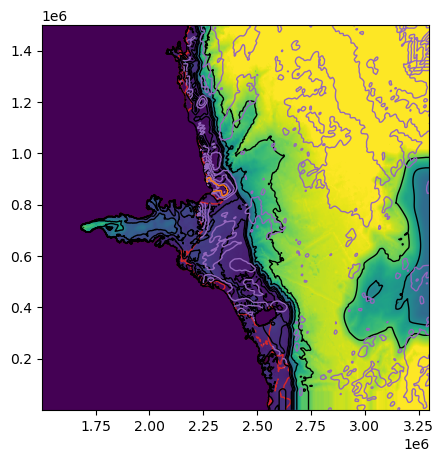

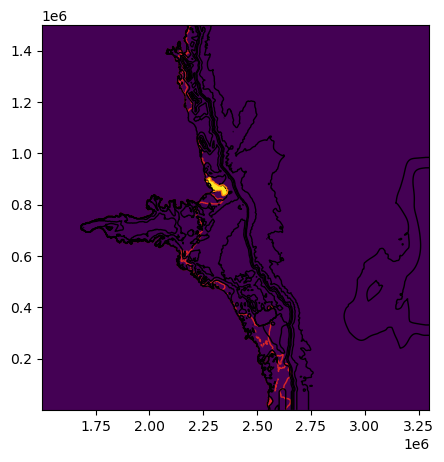

In [10]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

# paths = cs.get_paths()[0].to_polygons()
# plt.plot(paths[1][:,0],paths[1][:,1])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley
# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



In [ ]:
# # now load lima

# import rioxarray

# lima_full = rioxarray.open_rasterio('../data/raw/lima/00000-20080319-092059124.tif')

# lima = lima_full.where((lima_full.x>1.68e6)&(lima_full.x<2.5e6)&(lima_full.y>.4e6)&(lima_full.y<1e6),drop=True)


### finished preliminary loading data

In [11]:
# define time periods
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period)[-1].values)

winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[-1].values)

print('PROBABLY  SHOULD REDEFINE WINTER PERIOD WITH THE NEW DAYOFYEAR DATA')


256  to  316
71  to  131
246  to  306
61  to  121
PROBABLY  SHOULD REDEFINE WINTER PERIOD WITH THE NEW DAYOFYEAR DATA


#### make plots

In [53]:
# extract obs at a point

def extract_closest_ROMS(lon_target,lat_target,lon_field,lat_field):

    lat_diffs = np.abs(ds_CTRL.lat_rho - lat_target)
    lon_diffs = np.abs(ds_CTRL.lon_rho - lon_target)

    pyth_dist = (lat_diffs**2+lon_diffs**2)**0.5

    where = np.where(pyth_dist == pyth_dist.min())
    where_xi = where[1]
    where_eta = where[0]

    # lat_field.plot()
    # plt.show()
    # lon_field.plot()
    # plt.show()
    # (lat_field*lon_field).plot(vmax=0.01)
    # plt.plot(where_xi,where_eta,'x')
    # plt.axis((250,350,300,380))
    # plt.show()
    # (lat_field+lon_field).plot(vmax=0.1)
    # plt.plot(where_xi,where_eta,'x')
    # plt.axis((250,350,300,380))
    # plt.show()
    # ((lat_field**2+lon_field**2)**0.5).plot(vmax=0.1)
    # plt.plot(where_xi,where_eta,'x')
    # plt.axis((250,350,300,380))

    print('selected (xi,eta) at: (',where_xi,where_eta,') with lon/lat at: (',ds_CTRL.lon_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,ds_CTRL.lat_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,')')
    return where_xi,where_eta



lon_target_bh = 71.39169
lat_target_bh = -70.2284

lon_target_ds = 71.39599
lat_target_ds = -70.2256

lon_field = ds_CTRL.lat_rho
lat_field = ds_CTRL.lon_rho



bh_xi,bh_eta = extract_closest_ROMS(lon_target_bh,lat_target_bh,lon_field,lat_field)
ds_xi,ds_eta = extract_closest_ROMS(lon_target_ds,lat_target_ds,lon_field,lat_field)




selected (xi,eta) at: ( [278] [346] ) with lon/lat at: ( [[71.38141148]] [[-70.21361855]] )
selected (xi,eta) at: ( [278] [346] ) with lon/lat at: ( [[71.38141148]] [[-70.21361855]] )


<Figure size 640x480 with 0 Axes>

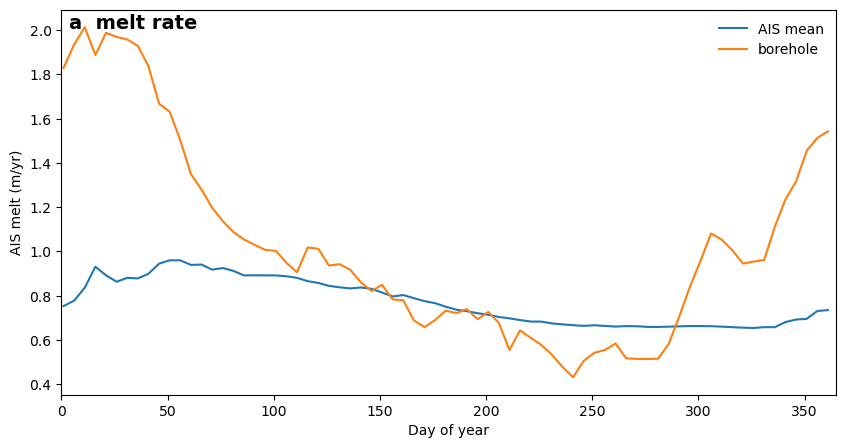

In [56]:
# make plot


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.4, hspace=0.15)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
ds_CTRL.my_doy.where(ds.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax,color='C0', linewidth=1.5,label='AIS mean')
ds_CTRL.my_doy.isel(xi_rho=bh_xi,eta_rho=bh_eta).plot(ax=ax,color='C1', linewidth=1.5,label='borehole')

ax.set_ylabel('AIS melt (m/yr)')
ax.text(0.01, 0.99, 'a  melt rate', transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
ax.set_title('')
ax.set_xlabel('Day of year')
# ax.set_xticklabels([])
ax.set_xlim((0,365))
ax.legend(frameon=False)

Text(0, 0.5, 'melt rate (m/yr)')

<Figure size 640x480 with 0 Axes>

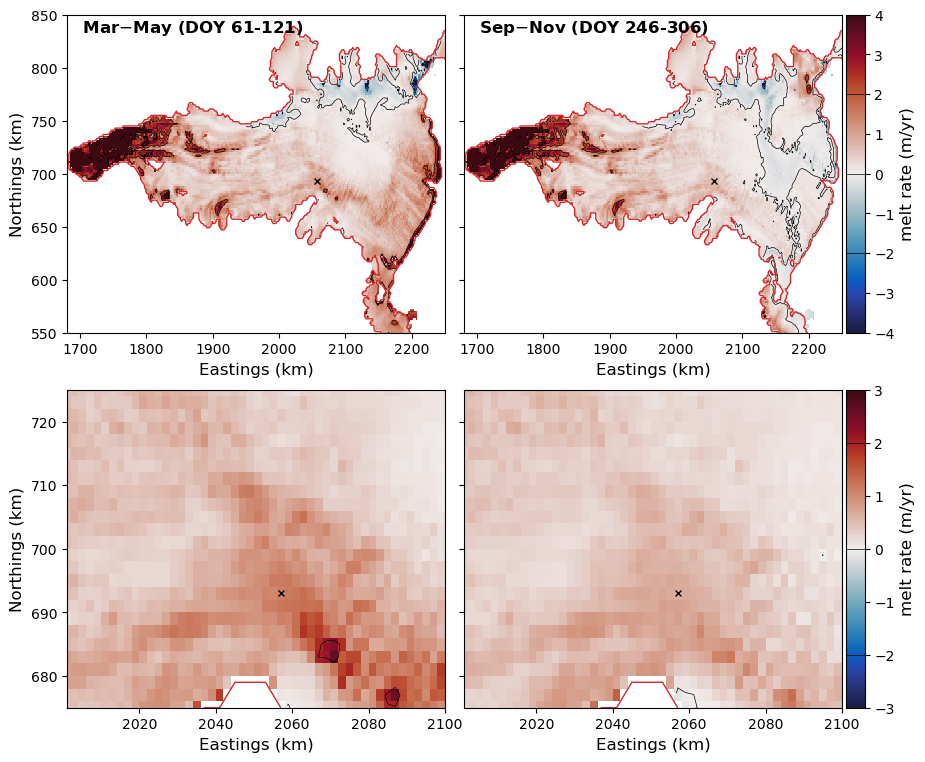

In [84]:
# spatial map




gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.05, hspace=0.18)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,9])
ax = None

ax=fig.add_subplot(gs[0,0])
# (lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=.5,
                                                                                                         levels=np.arange(-4,6,2))
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
plt.plot(ds_CTRL.x_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,ds_CTRL.y_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,'kx',markersize=4)

ax.text(0.01, 0.99, '  Mar$-$May (DOY 61-121)', transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
ax.set_ylabel('Northings (km)',fontsize=12)
ax.set_xlabel('Eastings (km)',fontsize=12)
# ax.set_xlabel('')
# ax.set_ylabel('')
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
ax.set_title('')

ax=fig.add_subplot(gs[1,0])
# (lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-3,vmax=3)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=.5,
                                                                                                         levels=np.arange(-4,6,2))
plt.plot(ds_CTRL.x_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,ds_CTRL.y_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,'kx',markersize=4)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((2.001e6,2.1e6))
ax.set_ylim((.675e6,.725e6))
ax.set_ylabel('Northings (km)',fontsize=12)
ax.set_xlabel('Eastings (km)',fontsize=12)
# ax.set_xlabel('')
# ax.set_ylabel('')
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
ax.set_title('')



#################


ax=fig.add_subplot(gs[0,1])
# (lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=.5,
                                                                                                         levels=np.arange(-4,6,2))
plt.plot(ds_CTRL.x_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,ds_CTRL.y_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,'kx',markersize=4)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=12)
ax.set_xlabel('Eastings (km)',fontsize=12)
# ax.set_xlabel('')
ax.set_ylabel('')
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, '  Sep$-$Nov (DOY 246-306)', transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cbar.add_lines(co1)
cax.set_ylabel(r'melt rate (m/yr)',fontsize=12)

ax=fig.add_subplot(gs[1,1])
# (lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-3,vmax=3)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=.5,
                                                                                                         levels=np.arange(-4,6,2))
plt.plot(ds_CTRL.x_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,ds_CTRL.y_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values,'kx',markersize=4)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((2.001e6,2.1e6))
ax.set_ylim((.675e6,.725e6))
# ax.set_ylabel('Northings (km)',fontsize=12)
ax.set_xlabel('Eastings (km)',fontsize=12)
# ax.set_xlabel('')
ax.set_ylabel('')
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cbar.add_lines(co1)
cax.set_ylabel(r'melt rate (m/yr)',fontsize=12)